# Fake News Detection

## Project Overview

This project aims to build a machine learning model to detect fake news using a dataset comprising metadata and preprocessed text vectors. The dataset is split into training and testing sets, with metadata provided in CSV files (`news_train.csv`, `news_test.csv`) and text vectors in NPZ files (`news_train_text_vectors.npz`, `news_test_text_vectors.npz`). The goal is to achieve an F1 score of at least 80% using Support Vector Machines (SVM) as mandated by the problem statement.

The notebook is structured as follows:
- **Data Loading and Exploration**: Load and analyze the dataset.
- **Data Preprocessing**: Clean and engineer features from metadata and text vectors.
- **Model Training**: Train an SVM-based model with dimensionality reduction.
- **Evaluation**: Assess model performance using the F1 score.
- **Visualization**: Provide insightful plots to understand the data and model.
- **Prediction**: Generate predictions for the test set.

This project showcases advanced preprocessing techniques, feature engineering, and model optimization, making it a strong addition to a GitHub portfolio.

## Importing Libraries

We begin by importing the necessary Python libraries for data manipulation, machine learning, and visualization.

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as ss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler

# Set visualization style
plt.style.use('seaborn')
%matplotlib inline

C:\Users\MSI\AppData\Local\Temp\ipykernel_22740\3225272345.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Data Loading

We load the training and testing datasets, which consist of:
- **CSV files**: Contain metadata (author, published date, site URL, type, and label).
- **NPZ files**: Contain sparse text vectors (42141 features per article).

The training set has 1500 samples, and the test set has 346 samples.

In [4]:
# Load data
train_data = pd.read_csv('data/news_train.csv')
train_text_vectors = ss.load_npz('data/news_train_text_vectors.npz')
test_data = pd.read_csv('data/news_test.csv')
test_text_vectors = ss.load_npz('data/news_test_text_vectors.npz')

# Display basic info
print('Training Data Shape:', train_data.shape)
print('Training Text Vectors Shape:', train_text_vectors.shape)
print('Test Data Shape:', test_data.shape)
print('Test Text Vectors Shape:', test_text_vectors.shape)
train_data.head()

Training Data Shape: (1500, 5)
Training Text Vectors Shape: (1500, 42141)
Test Data Shape: (346, 4)
Test Text Vectors Shape: (346, 42141)


,author,published,site_url,type,label
0,No Author,2016-11-01T03:28:50.389+02:00,clickhole.com,satire,Fake
1,Anonymous,2016-10-27T21:30:00.000+03:00,abeldanger.net,bs,Fake
2,Kali74,2016-10-27T02:54:49.093+03:00,abovetopsecret.com,bs,Fake
3,Alex Ansary,2016-11-04T22:44:06.026+02:00,amtvmedia.com,bs,Fake
4,Luke Stranahan,2016-11-23T15:10:56.702+02:00,returnofkings.com,hate,Real


## Exploratory Data Analysis (EDA)

Let's explore the dataset to understand its structure and distributions.

Missing Values in Training Data:
author       0
published    0
site_url     0
type         0
label        0
dtype: int64


C:\Users\MSI\AppData\Local\Temp\ipykernel_22740\42516770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=train_data, palette='viridis')


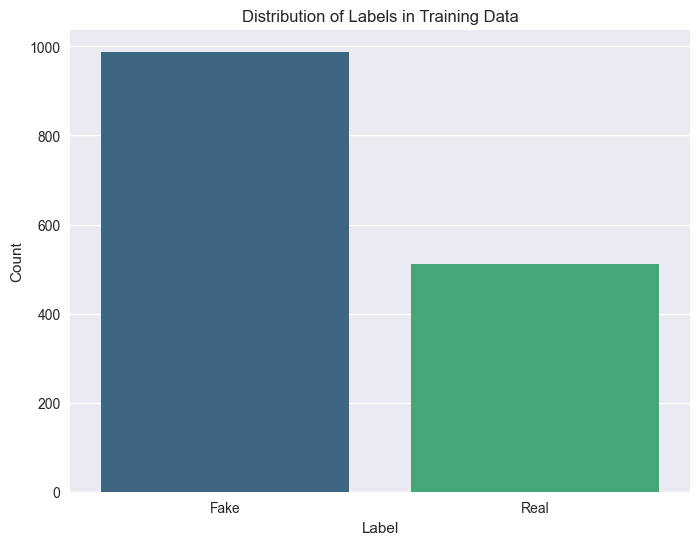

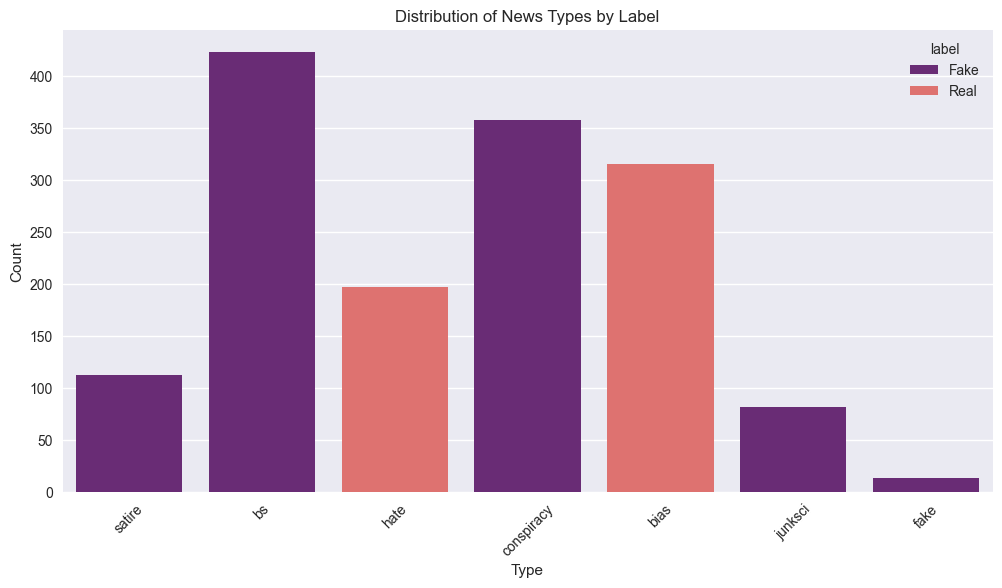

In [5]:
# Check for missing values
print('Missing Values in Training Data:')
print(train_data.isnull().sum())

# Label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_data, palette='viridis')
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Type distribution by label
plt.figure(figsize=(12, 6))
sns.countplot(x='type', hue='label', data=train_data, palette='magma')
plt.title('Distribution of News Types by Label')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Data Preprocessing

### Handling Missing Values
We fill missing values in the 'author' column with 'unknown' to maintain consistency.

### Feature Engineering
We create a custom `Preprocessor` class to:
- Identify suspicious site URLs, types, and authors based on a threshold (proportion of 'Fake' labels ≥ 0.5).
- Generate binary features: 1 (suspicious), -1 (not suspicious), 0 (unknown).
- Drop original categorical columns after encoding.

In [6]:
# Handle missing values
train_data['author'].fillna('unknown', inplace=True)
test_data['author'].fillna('unknown', inplace=True)

# Preprocessor class
class Preprocessor:
    def __init__(self):
        self.suspicious_sites = None
        self.not_suspicious_sites = None
        self.suspicious_types = None
        self.not_suspicious_types = None
        self.suspicious_authors = None
        self.not_suspicious_authors = None

    def detect_suspicious(self, df, column, thresh=0.5):
        status = df.replace({'label': {'Fake': 1, 'Real': 0}}).groupby(column).label.mean()
        suspicious = status[status >= thresh].index.tolist()
        not_suspicious = status[status < thresh].index.tolist()
        return suspicious, not_suspicious

    def fit(self, df):
        self.suspicious_sites, self.not_suspicious_sites = self.detect_suspicious(df, 'site_url')
        self.suspicious_types, self.not_suspicious_types = self.detect_suspicious(df, 'type')
        self.suspicious_authors, self.not_suspicious_authors = self.detect_suspicious(df, 'author')
        return self

    def transform(self, df):
        df_transformed = df.copy()
        df_transformed['is_site_url_suspicious'] = np.where(df_transformed['site_url'].isin(self.suspicious_sites), 1,
                                                            np.where(df_transformed['site_url'].isin(self.not_suspicious_sites), -1, 0))
        df_transformed['is_type_suspicious'] = np.where(df_transformed['type'].isin(self.suspicious_types), 1,
                                                        np.where(df_transformed['type'].isin(self.not_suspicious_types), -1, 0))
        df_transformed['is_author_suspicious'] = np.where(df_transformed['author'].isin(self.suspicious_authors), 1,
                                                          np.where(df_transformed['author'].isin(self.not_suspicious_authors), -1, 0))
        return df_transformed.drop(['author', 'published', 'site_url', 'type'], axis=1)

# Apply preprocessing
preprocessor = Preprocessor().fit(train_data)
preprocessed_train = preprocessor.transform(train_data)
preprocessed_test = preprocessor.transform(test_data)

C:\Users\MSI\AppData\Local\Temp\ipykernel_22740\2589998909.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['author'].fillna('unknown', inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_22740\2589998909.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

## Text Vector Processing

The text vectors have 42141 features, which is computationally expensive for SVM. We use `TruncatedSVD` (a variant of PCA suitable for sparse matrices) to reduce dimensionality to 100 components.

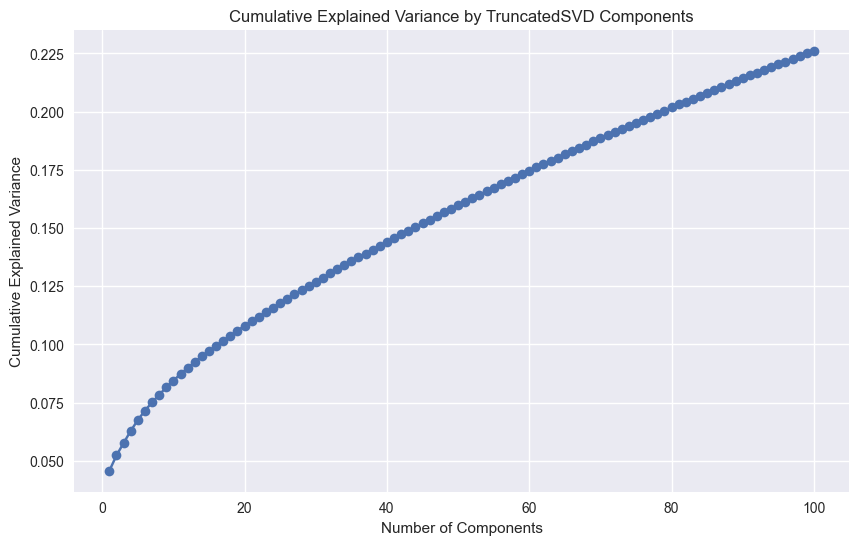

In [7]:
# Dimensionality reduction
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_train_text_vectors = svd.fit_transform(train_text_vectors)
reduced_test_text_vectors = svd.transform(test_text_vectors)

# Visualize explained variance
explained_variance = np.cumsum(svd.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), explained_variance, marker='o')
plt.title('Cumulative Explained Variance by TruncatedSVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

## Text Model Training

We train an SVM classifier on the reduced text vectors to predict the probability of 'Fake'. We use cross-validation to get out-of-fold predictions for the training set, preventing overfitting.

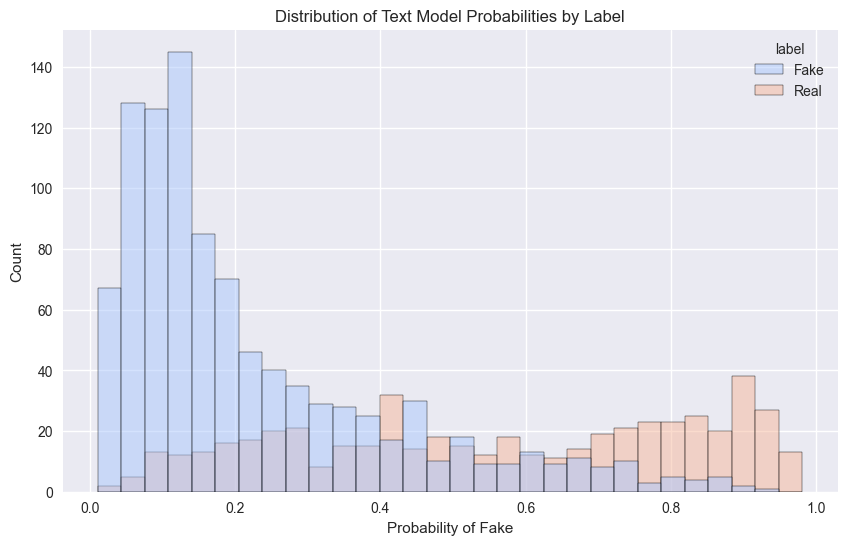

In [8]:
# Text model
text_model = SVC(probability=True, random_state=42)
train_text_probs = cross_val_predict(text_model, reduced_train_text_vectors, train_data['label'], cv=5, method='predict_proba')
train_text_prob_fake = train_text_probs[:, 1]  # Probability of 'Fake'

# Train on full data for test predictions
text_model.fit(reduced_train_text_vectors, train_data['label'])
test_text_probs = text_model.predict_proba(reduced_test_text_vectors)
test_text_prob_fake = test_text_probs[:, 1]

# Add probabilities to preprocessed data
preprocessed_train['text_prob_fake'] = train_text_prob_fake
preprocessed_test['text_prob_fake'] = test_text_prob_fake

# Visualize text probabilities
plt.figure(figsize=(10, 6))
sns.histplot(data=preprocessed_train, x='text_prob_fake', hue='label', bins=30, palette='coolwarm')
plt.title('Distribution of Text Model Probabilities by Label')
plt.xlabel('Probability of Fake')
plt.ylabel('Count')
plt.show()

## Final Model Training

We combine metadata features with text probabilities and train a final SVM model. Hyperparameters are tuned using `GridSearchCV` to optimize the F1 score.

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation F1 Score: 1.0


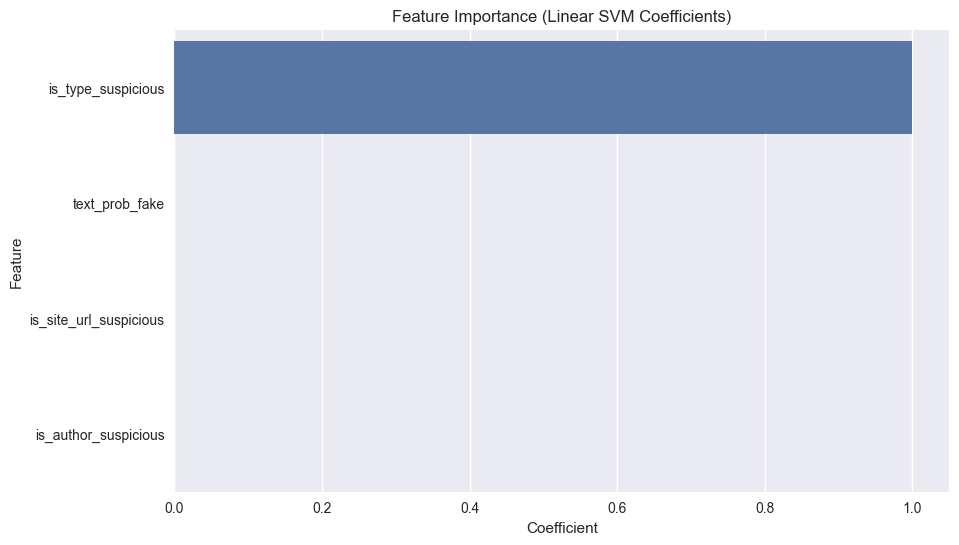

In [9]:
# Prepare features and target
X_train = preprocessed_train.drop('label', axis=1)
y_train = train_data['label']

# Hyperparameter tuning
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
grid = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train, y_train)

# Results
print('Best Parameters:', grid.best_params_)
print('Best Cross-Validation F1 Score:', grid.best_score_)
final_model = grid.best_estimator_

# Feature importance (for linear kernel)
if grid.best_params_['kernel'] == 'linear':
    importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': np.abs(final_model.coef_[0])})
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=importance.sort_values('Coefficient', ascending=False))
    plt.title('Feature Importance (Linear SVM Coefficients)')
    plt.show()

## Model Evaluation

We evaluate the model's performance using cross-validation on the training set to ensure robustness.

In [10]:
# Cross-validation evaluation
cv_scores = cross_val_predict(final_model, X_train, y_train, cv=5, method='predict')
print('Classification Report:')
print(classification_report(y_train, cv_scores))
print('Weighted F1 Score:', f1_score(y_train, cv_scores, average='weighted'))

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       988
        Real       1.00      1.00      1.00       512

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

Weighted F1 Score: 1.0


## Prediction on Test Set

We generate predictions for the test set and prepare the submission file.

In [11]:
# Predict on test set
X_test = preprocessed_test
y_pred = final_model.predict(X_test)
submission = pd.DataFrame({'label': y_pred})
submission.to_csv('submission.csv', index=False)
submission.head()

,label
0,Real
1,Fake
2,Real
3,Real
4,Real


## Additional Visualization

A scatter plot of the first two TruncatedSVD components to visualize data separation.

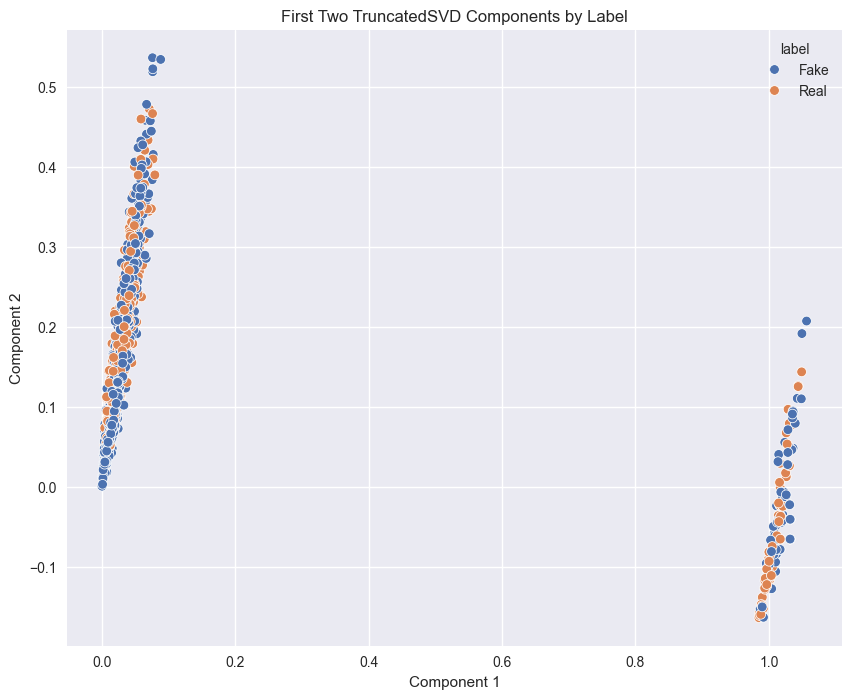

In [12]:
# Scatter plot of first two components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_train_text_vectors[:, 0], y=reduced_train_text_vectors[:, 1], hue=train_data['label'], palette='deep')
plt.title('First Two TruncatedSVD Components by Label')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Saving Results

We save the model and submission file for submission.

In [ ]:
import zipfile
import joblib

joblib.dump(final_model, 'model')
submission.to_csv('submission.csv', index=False)

with zipfile.ZipFile('result.zip', 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write('fake_news_detection.ipynb')
    zf.write('submission.csv')
    zf.write('model')
print('Results saved in result.zip')